In [ ]:
from lambeq import BobcatParser, SpacyTokeniser, AtomicType, IQPAnsatz, Rewriter

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

parser = BobcatParser(verbose="suppress")
tokeniser = SpacyTokeniser()
rewriter = Rewriter(['prepositional_phrase', 'determiner'])
def process_diagrams(sentences, diagrams):
    for sentence in sentences:
        try:
            #sentence = tokeniser.split_sentences(sentence) #for more complex sentences this will be needed, but breaks single sentence itterances
            tokens = tokeniser.tokenise_sentence(sentence)
            diagram = parser.sentence2diagram(tokens, tokenised=True)
            #rewrite rule for prepositional phrases
            rewritten_diagram = rewriter(diagram)
            #normalize diagram
            normalised_diagram = rewritten_diagram.normal_form() #explore more rewriting ideas
            diagrams.append(normalised_diagram)
        except Exception as e:
            print(f"Failed to parse: {sentence}")

english_diagrams = []
russian_diagrams = []
english_sentences = []
russian_sentences = []

try:
    with open("english.txt", "r", encoding="utf-8") as f:
        for line in f:
            english_sentences.append(line.strip())
except FileNotFoundError:
    print("Wrong file name")
except UnicodeDecodeError:
    print("missed utf-8 encoding")

# try:
#     with open("russian.txt", "r") as f:   #need diagram creator for russian
#         for line in f:
#             russian_sentences.append(line.strip())
# except FileNotFoundError:
#     print("Error: 'russian.txt' not found.")
#
# russian_diagrams = process_diagrams(russian_sentences)

 
process_diagrams(english_sentences, english_diagrams)
#process_diagrams("russian.txt", russian_diagrams)


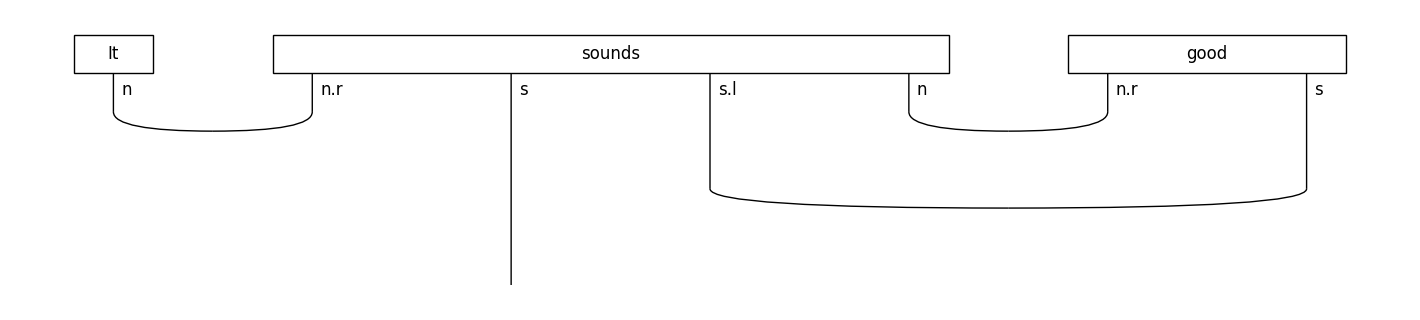

In [ ]:
#append to file after every 20 diagrams
english_diagrams[15562].draw(figsize=(14,3), fontsize=12)

In [ ]:
from lambeq import AtomicType, IQPAnsatz
english_circuits = []
russian_circuits = []
def process_circuits(diagrams, circuits):
    #Define atomic types
    N = AtomicType.NOUN
    S = AtomicType.SENTENCE
    ansatz = IQPAnsatz({N:1, S:1}, n_layers=2, n_single_qubit_params=3)
    for i,diagram in enumerate(diagrams):
        try:
    #Convert string Diagram to quantum circuit
            circuit = ansatz(diagram)
            #circuit.draw(figsize=(15,10))
            circuits.append(circuit)
        except Exception as e:
            print(f"Failed to convert diagram at sentence number {i+1}")
process_circuits(english_diagrams,english_circuits)
       


Failed to convert diagram at sentence number 863
Failed to convert diagram at sentence number 864
Failed to convert diagram at sentence number 865
Failed to convert diagram at sentence number 1525
Failed to convert diagram at sentence number 1526
Failed to convert diagram at sentence number 1527
Failed to convert diagram at sentence number 1847
Failed to convert diagram at sentence number 1848
Failed to convert diagram at sentence number 1849
Failed to convert diagram at sentence number 2399
Failed to convert diagram at sentence number 2424
Failed to convert diagram at sentence number 2425
Failed to convert diagram at sentence number 2612
Failed to convert diagram at sentence number 2613
Failed to convert diagram at sentence number 2681
Failed to convert diagram at sentence number 2682
Failed to convert diagram at sentence number 2683
Failed to convert diagram at sentence number 2684
Failed to convert diagram at sentence number 2685
Failed to convert diagram at sentence number 2686
Fai

In [ ]:
#PRINT TO FILE
def save_diagram(diagram, filename):
    """Saves a single diagram to a file."""
    try:
        diagram.draw(figsize=(14, 3), fontsize=12, filename=filename)
        print(f"Diagram saved to {filename}")
    except AttributeError:
        print(f"Error: Diagram object does not have a 'draw' method with 'filename' argument.")
        print("Please check the english_diagrams library documentation for saving options.")
    except Exception as e:
        print(f"An error occurred while saving {filename}: {e}")

# Save each diagram in the list to a separate file
diagrams = english_diagrams
for i, diagram in enumerate(diagrams):
    filename = f"diagram_{i+1}.png" # Or another suitable format like .svg, if supported
    save_diagram(diagram, filename)

print("Finished saving all diagrams.")

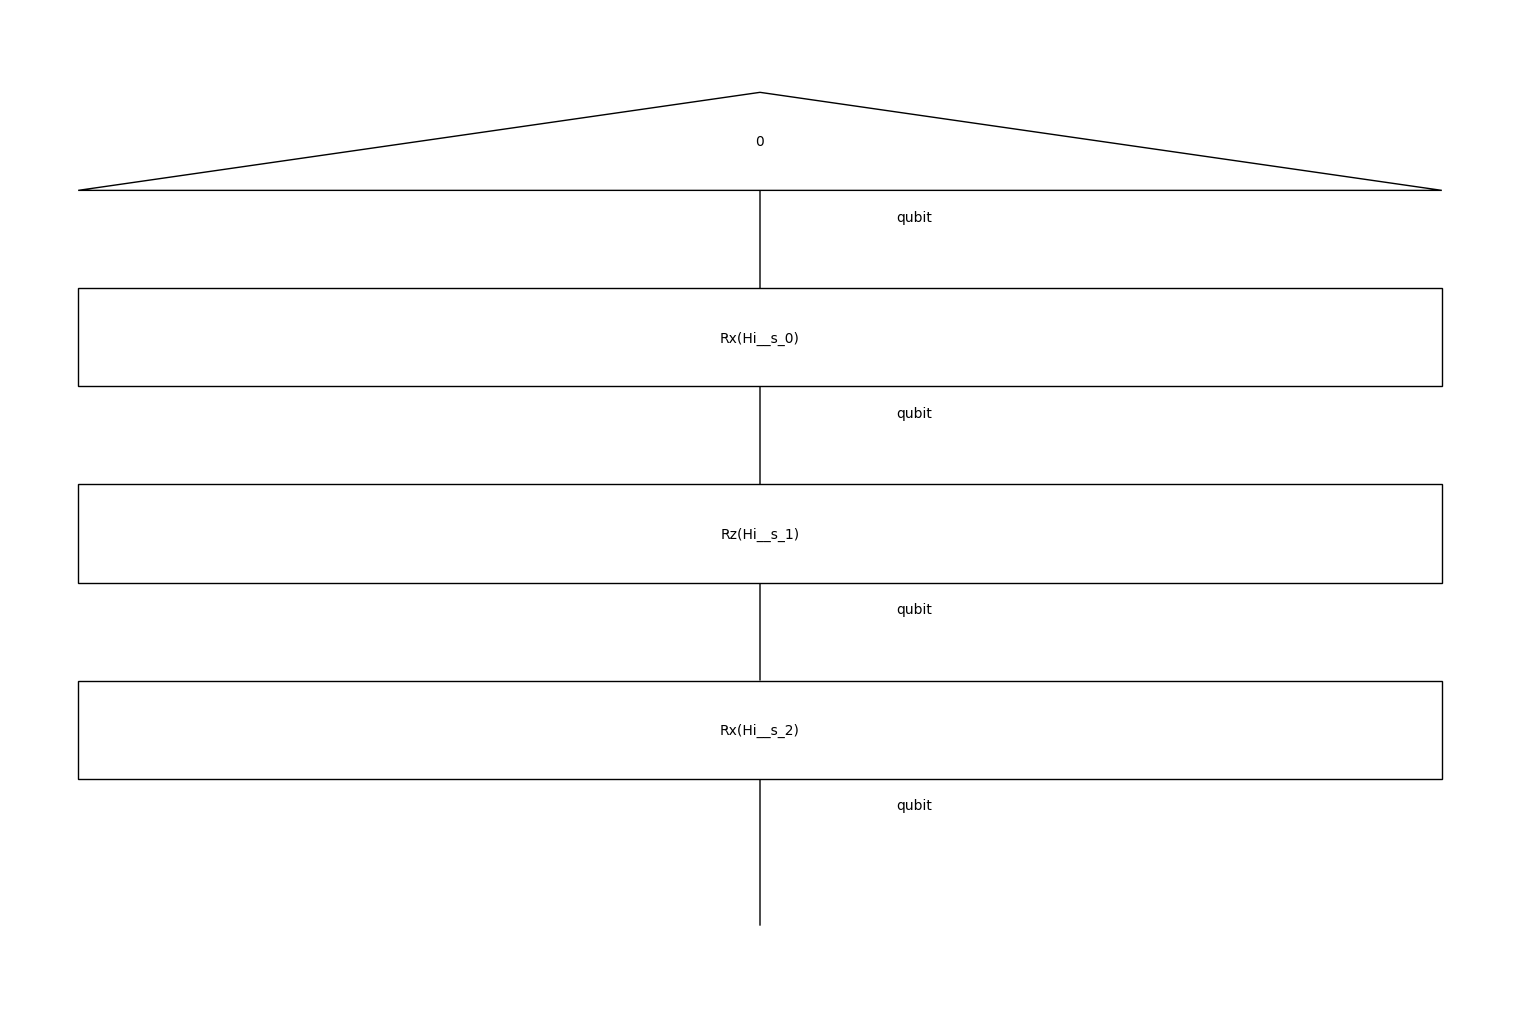

In [ ]:
#debug cell
N = AtomicType.NOUN
S = AtomicType.SENTENCE
ansatz = IQPAnsatz({N:1, S:1}, n_layers=2)
circuit = ansatz(parser.sentence2diagram("Hi"))
circuit.draw(figsize=(15,10))

In [7]:
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42
import torch
import random
import numpy as np
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)


In [ ]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [ ]:
from lambeq import PennyLaneModel

all_circuits = russian_circuits + english_circuits

backend_config = {'backend': 'default.qubit'}
model = PennyLaneModel.from_diagrams(all_circuits, probabilities=True, normalize=True,backend_config=backend_config)
model.initialise_weights()

In [ ]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [ ]:
import pennylane as qml
qml.default_config['qiskit.ibmq.ibmqx_token'] = 'my_API_token'
qml.default_config.save(qml.default_config.path)
backend_config = {'backend': 'qiskit.ibmq',
                  'device': 'ibmq_manilia',
                  'shots': 1000}
q_model = PennyLaneModel.from_diagrams(all_circuits, probabilities=True, normalize=True, backend_config=backend_config)
#q_model = initialise_weights()

In [ ]:

#trainer.fit(train_dataset, val_dataset)